# Imports

In [ ]:
# Install the necessary Python packages
!pip install numpy
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install Pillow

In [1]:
# prerequisites
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from collections import deque
from sklearn.manifold import TSNE

# Download Dataset

In [2]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Section 1: Autoencoder

In [3]:
class Autoencoder(nn.Module):

  def __init__(
      self,
      input_dim: int = 784,
      hidden_dim: int = 256,
      latent_dim: int = 6,
      device: str = "cuda"
  ):
    super(Autoencoder, self).__init__()
    self.device = device
    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, latent_dim),
        nn.ReLU(inplace=True)
    )

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid() # to get pixel values between 0 and 1
    )

    # Choose the correct final layer output activation

    ######### Your code ends here #########

  def forward(self, x):
    B = x.shape[0]
    x = x.reshape(B, -1)
    latent = self.encoder(x)
    reconstruction = self.decoder(latent)
    reconstruction = reconstruction.reshape(B, 1, 28, 28)

    self.latent = latent
    return reconstruction



# create buffer class for storing latent representations and labels
# torch.Size([100, 1, 28, 28]) torch.Size([100])
# torch.float32 torch.int64
class Buffer:
  def __init__(self, size: int = 1000):
    self.size = size
    self.latents = deque(maxlen=size)
    self.labels = deque(maxlen=size)
  
  def add(self, latent: torch.Tensor, label: torch.Tensor):
    self.latents.append(latent)
    self.labels.append(label)
  
  def add_batch(self, latents: torch.Tensor, labels: torch.Tensor):
    for i in range(latents.shape[0]):
      self.add(latents[i], labels[i])

  def sample(self, label=None):
    if label is None:
      idx = np.random.randint(self.size)
    else:
      idx = np.random.choice(np.where(np.array(self.labels) == label)[0])
    return self.latents[idx], self.labels[idx]
  
  def get_latents_and_labels(self):
    latents_tensor = torch.stack([latent for latent in self.latents])
    labels_tensor = torch.stack([label for label in self.labels])
    return latents_tensor, labels_tensor


# Section 2: Variational Autoencoder

In [4]:
class Split(torch.nn.Module):
  """
  nn layer that provides n heads for multiple output layers
  """
  def __init__(self, *modules: torch.nn.Module):
      super().__init__()
      self.modules = modules

  def forward(self, inputs):
      return [module(inputs) for module in self.modules]

class VAE(nn.Module):

  def __init__(self, input_dim: int = 784, hidden_dim: int = 256, latent_dim: int = 2, device: str = "cuda"):
    super(VAE, self).__init__()
    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.device = device

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations

    # Separate linear layers to predict the latent mean and logvar

    # Choose the correct final layer output activation

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(inplace=True),
        Split(
            nn.Linear(hidden_dim, latent_dim), # mean layer
            nn.Linear(hidden_dim, latent_dim), # logvar layer
        )
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid(), # to get pixel values between 0 and 1
        nn.Unflatten(1, (1, 28, 28))
    )

    ######### Your code ends here #########

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

  def sample(self, n):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    return self.decoder(sample)

  def forward(self, x):
    mu, log_var = self.encoder(x) # logvar instead of variance for numerical stability
    z = self.reparameterize(mu, log_var)
    reconstruction = self.decoder(z)
    self.latent = z
    return reconstruction, mu, log_var

# Training Loop

In [5]:
def _get_recon_and_loss(model_cls, model, loss_fn, data, class_label=None):
  if model_cls == "ae":
    recon_batch = model(data)
    loss = loss_fn(recon_batch, data)

  elif model_cls == "vae":
    recon_batch, mu, log_var = model(data)
    loss = loss_fn(recon_batch, data, mu, log_var)

  elif model_cls == "cvae":
    recon_batch, mu, log_var = model(data, class_label)
    loss = loss_fn(recon_batch, data, mu, log_var)

  else:
    raise NotImplementedError
  
  return recon_batch, loss
    
@torch.no_grad()
def test_single_epoch(
    model_cls: str,
    model: nn.Module,
    loss_fn: Callable,
    data_loader: DataLoader,
    epoch: int,
    buffer: Buffer = None
):
  model.eval()
  test_loss = 0
  for batch_idx, (data, class_label) in enumerate(data_loader):
    data = data.to(device)
    class_label = class_label.to(device)

    _, loss = _get_recon_and_loss(model_cls, model, loss_fn, data, class_label)
    test_loss += loss.item()
    buffer.add_batch(model.latent, class_label)


  avg_test_loss = test_loss / len(data_loader.dataset)
  print('====> Epoch: {} Average test loss: {:.6f}'.format(epoch, avg_test_loss))
  return avg_test_loss
  

def train_single_epoch(
    model_cls: str,
    model: nn.Module,
    loss_fn: Callable,
    data_loader: DataLoader,
    optimizer,
    epoch: int
):
  # set model to training mode
  model.train()
  train_loss = 0
  for batch_idx, (data, class_label) in enumerate(data_loader):
    data = data.to(device)
    class_label = class_label.to(device)

    optimizer.zero_grad()
    recon_batch, loss = _get_recon_and_loss(model_cls, model, loss_fn, data, class_label)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

    # if batch_idx % log_interval == 0:
    #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #         epoch, batch_idx * len(data), len(data_loader.dataset),
    #         100. * batch_idx / len(data_loader), loss.item() / len(data)))
  
  avg_loss = train_loss / len(data_loader.dataset)
  print('====> Epoch: {} Average loss: {:.6f}'.format(epoch, avg_loss))
  
  # Plot reconstructions
  n = min(num_examples, 8)
  imgs = data[:n]
  reconstructed_imgs = recon_batch.view(batch_size,-1, 28, 28)[:n]

  comparisons = torch.cat([imgs, reconstructed_imgs])

  # sample some from the latent space, with class label 0
  if model_cls in ["vae", "cvae"]:
    latent_samples = model.sample(n=n)
    latent_samples = latent_samples.view(n, -1, 28, 28)
    comparisons = torch.cat([comparisons, latent_samples])

  comparisons = torchvision.utils.make_grid(comparisons)
  comparisons = comparisons.detach().cpu().numpy()

  print("Reconstructions: ")
  plt.imshow(comparisons.transpose(1,2,0))
  plt.axis('off')
  plt.show()


  return avg_loss


# Section 3: Train Autoencoder


====== Training Autoencoder with latent dimension 32 ======
====> Epoch: 0 Average loss: 0.002142
Reconstructions: 


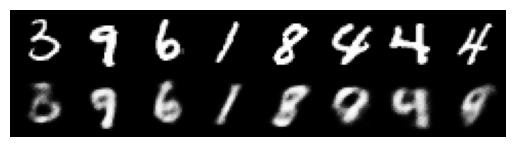

====> Epoch: 0 Average test loss: 0.001485
====> Epoch: 1 Average loss: 0.001361
Reconstructions: 


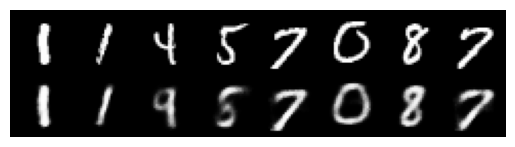

====> Epoch: 1 Average test loss: 0.001233
====> Epoch: 2 Average loss: 0.001194
Reconstructions: 


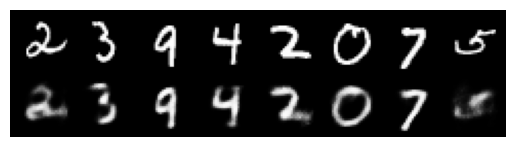

====> Epoch: 2 Average test loss: 0.001126
====> Epoch: 3 Average loss: 0.001103
Reconstructions: 


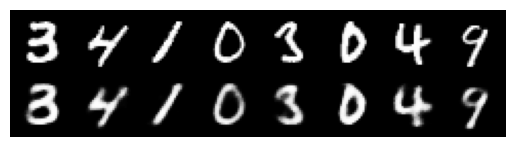

====> Epoch: 3 Average test loss: 0.001057
====> Epoch: 4 Average loss: 0.001051
Reconstructions: 


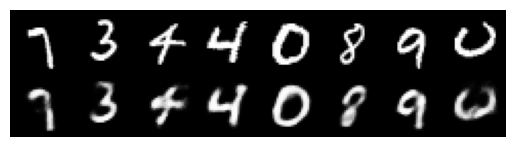

====> Epoch: 4 Average test loss: 0.001020
====> Epoch: 5 Average loss: 0.001016
Reconstructions: 


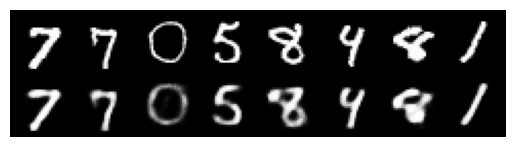

====> Epoch: 5 Average test loss: 0.000986
====> Epoch: 6 Average loss: 0.000987
Reconstructions: 


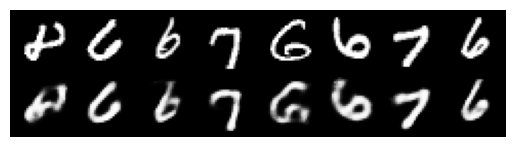

====> Epoch: 6 Average test loss: 0.000965
====> Epoch: 7 Average loss: 0.000963
Reconstructions: 


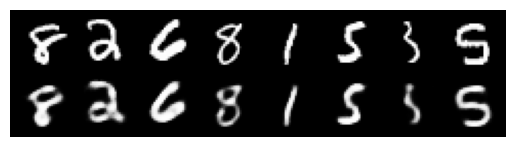

====> Epoch: 7 Average test loss: 0.000943
====> Epoch: 8 Average loss: 0.000943
Reconstructions: 


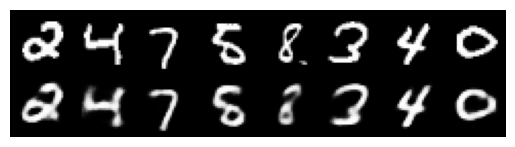

====> Epoch: 8 Average test loss: 0.000923
====> Epoch: 9 Average loss: 0.000925
Reconstructions: 


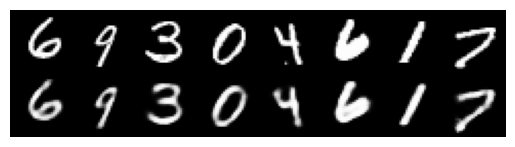

====> Epoch: 9 Average test loss: 0.000907

====== Training Autoencoder with latent dimension 128 ======
====> Epoch: 0 Average loss: 0.002099
Reconstructions: 


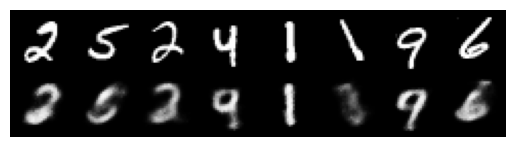

====> Epoch: 0 Average test loss: 0.001470
====> Epoch: 1 Average loss: 0.001335
Reconstructions: 


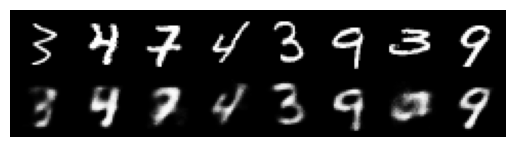

====> Epoch: 1 Average test loss: 0.001216
====> Epoch: 2 Average loss: 0.001163
Reconstructions: 


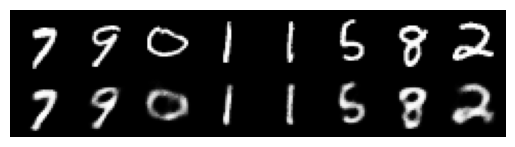

====> Epoch: 2 Average test loss: 0.001088
====> Epoch: 3 Average loss: 0.001065
Reconstructions: 


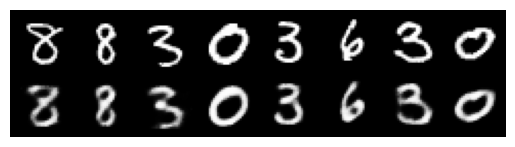

====> Epoch: 3 Average test loss: 0.001020
====> Epoch: 4 Average loss: 0.001007
Reconstructions: 


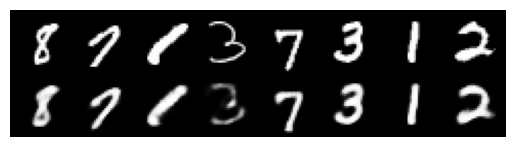

====> Epoch: 4 Average test loss: 0.000969
====> Epoch: 5 Average loss: 0.000963
Reconstructions: 


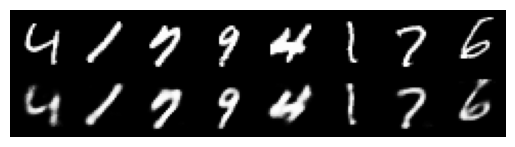

====> Epoch: 5 Average test loss: 0.000936
====> Epoch: 6 Average loss: 0.000936
Reconstructions: 


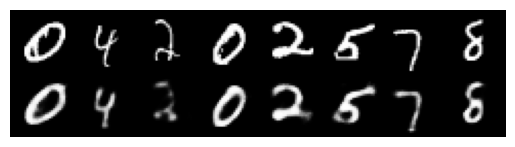

====> Epoch: 6 Average test loss: 0.000914
====> Epoch: 7 Average loss: 0.000915
Reconstructions: 


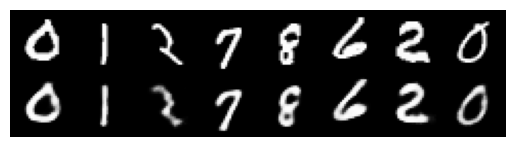

====> Epoch: 7 Average test loss: 0.000895
====> Epoch: 8 Average loss: 0.000896
Reconstructions: 


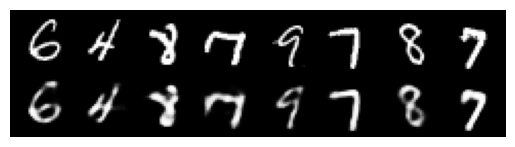

====> Epoch: 8 Average test loss: 0.000876
====> Epoch: 9 Average loss: 0.000878
Reconstructions: 


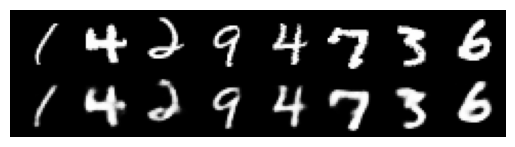

====> Epoch: 9 Average test loss: 0.000861

====== Training Autoencoder with latent dimension 512 ======
====> Epoch: 0 Average loss: 0.001982
Reconstructions: 


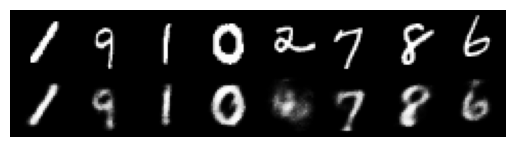

====> Epoch: 0 Average test loss: 0.001358
====> Epoch: 1 Average loss: 0.001223
Reconstructions: 


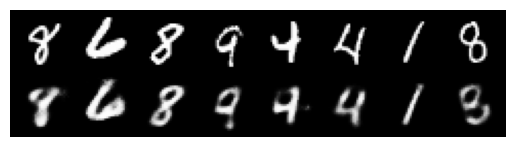

====> Epoch: 1 Average test loss: 0.001107
====> Epoch: 2 Average loss: 0.001065
Reconstructions: 


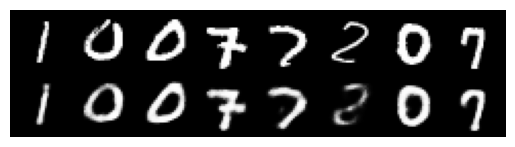

====> Epoch: 2 Average test loss: 0.001010
====> Epoch: 3 Average loss: 0.000992
Reconstructions: 


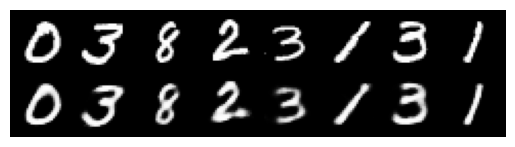

====> Epoch: 3 Average test loss: 0.000948
====> Epoch: 4 Average loss: 0.000941
Reconstructions: 


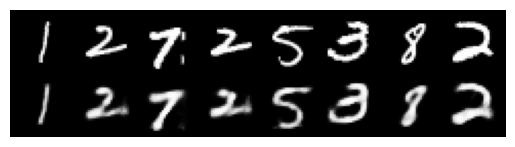

====> Epoch: 4 Average test loss: 0.000908
====> Epoch: 5 Average loss: 0.000908
Reconstructions: 


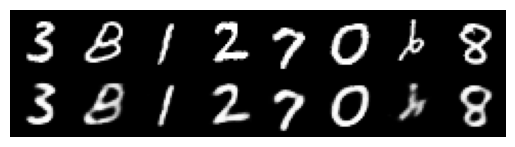

====> Epoch: 5 Average test loss: 0.000883
====> Epoch: 6 Average loss: 0.000882
Reconstructions: 


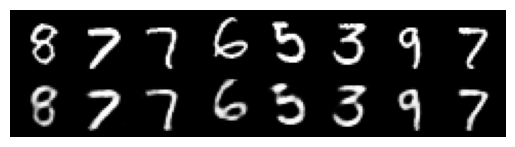

====> Epoch: 6 Average test loss: 0.000861
====> Epoch: 7 Average loss: 0.000862
Reconstructions: 


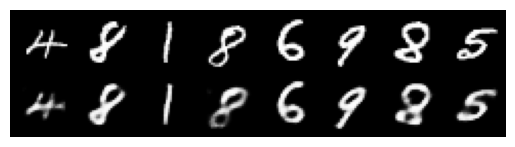

====> Epoch: 7 Average test loss: 0.000846
====> Epoch: 8 Average loss: 0.000846
Reconstructions: 


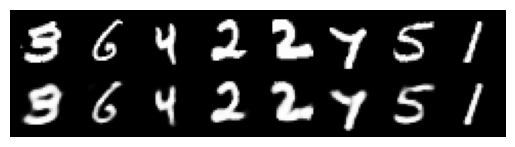

====> Epoch: 8 Average test loss: 0.000831
====> Epoch: 9 Average loss: 0.000832
Reconstructions: 


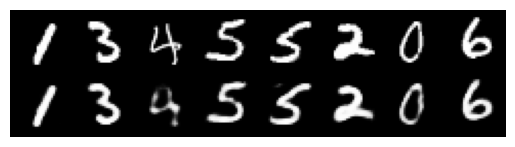

====> Epoch: 9 Average test loss: 0.000817


In [6]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"


hidden_dim = 128
latent_dims = [32, 128, 512]

all_losses = {
  f"ae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in latent_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dims = [512]
  num_epochs = 2

for latent_dim in latent_dims:
  # build model and buffer
  ae = Autoencoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device
  )
  buffer = Buffer(size=5000)


  # put model on device
  if torch.cuda.is_available():
    ae.cuda()

  # device optimizer
  optimizer = optim.Adam(ae.parameters())

  ######### Your code starts here #########
  # Define the loss function for a vanilla Autoencoder.
  loss_fn = nn.BCELoss()
  ######### Your code ends here #########

  # train
  print(f"\n====== Training Autoencoder with latent dimension {latent_dim} ======")
  for epoch in range(0, num_epochs):
    train_loss_epoch = train_single_epoch(
      model_cls="ae",
      model=ae,
      loss_fn=loss_fn,
      data_loader=train_loader,
      optimizer=optimizer,
      epoch=epoch
    )

    test_loss_epoch = test_single_epoch(
      model_cls="ae",
      model=ae,
      loss_fn=loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"ae{latent_dim}"]["train_losses"].append(train_loss_epoch)
    all_losses[f"ae{latent_dim}"]["test_losses"].append(test_loss_epoch)
  models[f"ae{latent_dim}"] = ae
  buffers[f"ae{latent_dim}"] = buffer

# Visualization

In [9]:
def viz_samples_ae(model, buffer, model_key, title):
    """
    first row is embeddings taken directly from testing set, second and row third are embeddings sampled from the latent space. 
    sampling is done by adding Gaussian perturbations
    """
    num_samples = 9
    embeddings_test = [buffer.sample()[0] for _ in range(num_samples)]
    comparisons = torch.stack(embeddings_test)
    comparisons = torch.concat([
        comparisons,
        comparisons + torch.randn_like(comparisons) * 2,
        comparisons + torch.randn_like(comparisons) * 4
        ],
    )

    comparisons = model.decoder(comparisons).view(num_samples * 3,1,28,28)
    comparisons = torchvision.utils.make_grid(comparisons, nrow=num_samples)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_samples_vae(model, model_key, title):
    comparisons = model.sample(25)
    comparisons = torchvision.utils.make_grid(comparisons, nrow=10)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_samples_cvae(model, model_key, title):
    comparisons = torch.cat([model.sample(1, class_label=i) for _ in range(3) for i in range(10)])
    comparisons = torchvision.utils.make_grid(comparisons, nrow=10)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_tsne(buffer, model_key, title):
    latents, labels = buffer.get_latents_and_labels()
    latents = latents.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    out = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(latents)

    plt.figure()
    plt.scatter(out[:,0], out[:,1], s=5, c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_tsne.png")


def plot_losses(all_losses: dict, model_cls: str, latent_dims: list, title: str, fout: str):
    """
    Expects a dictionary of the form:
    all_losses = {
        dim (str): {
            "train_losses": [],
            "test_losses": []
        }
    }
    """
    plt.figure()
    fig, _ = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(8,6))
    for dim, ax in zip(latent_dims, plt.gcf().axes):
        ax.plot(all_losses[f"{model_cls}{dim}"]["train_losses"], label="Train loss", color="blue")
        ax.plot(all_losses[f"{model_cls}{dim}"]["test_losses"], label="Test loss", color="red")
        ax.set_title(f"Latent dim: {dim}")
    plt.suptitle(title)
    plt.legend()

    plt.gcf().text(0.5, 0.04, 'Epoch', ha='center', va='center')
    plt.gcf().text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.savefig(f"output/p3/{fout}.png")



<Figure size 640x480 with 0 Axes>

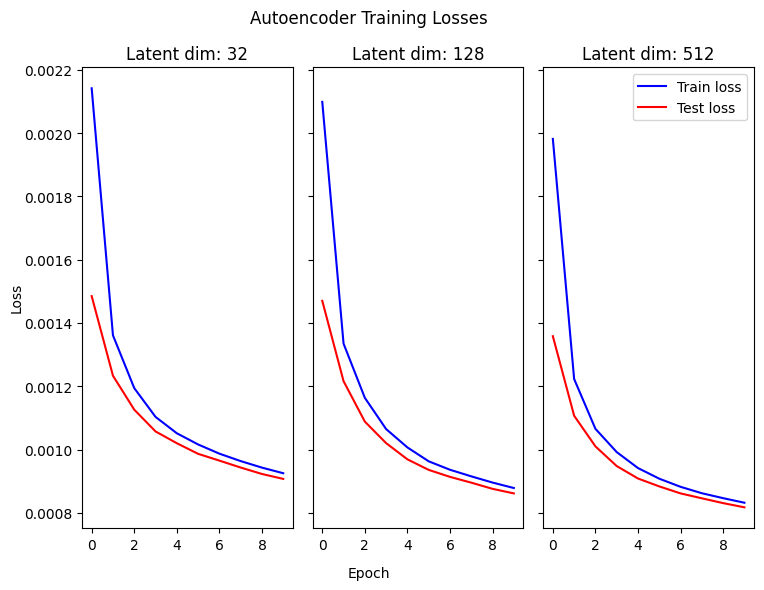

In [10]:
for model_key in ["ae32", "ae128", "ae512"]:
  model = models[model_key]
  buffer = buffers[model_key]

  plt.clf()

  title = f"Autoencoder samples: latent={model.latent_dim}"
  viz_samples_ae(model, buffer, model_key, title)

  title = f"Autoencoder latent space: latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "ae", latent_dims, f"Autoencoder Training Losses", "ae_losses")

# Section 4: Train Variational Autoencoder

====> Epoch: 0 Average loss: 200.698083
Reconstructions: 


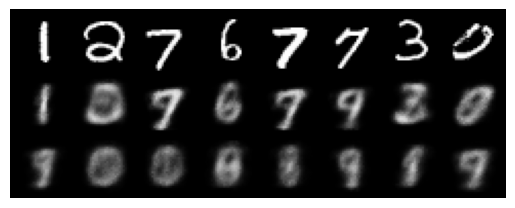

====> Epoch: 0 Average test loss: 172.929015
====> Epoch: 1 Average loss: 162.697203
Reconstructions: 


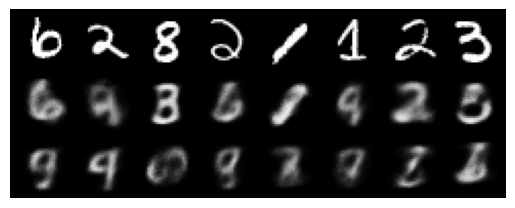

====> Epoch: 1 Average test loss: 154.707379
====> Epoch: 2 Average loss: 151.410857
Reconstructions: 


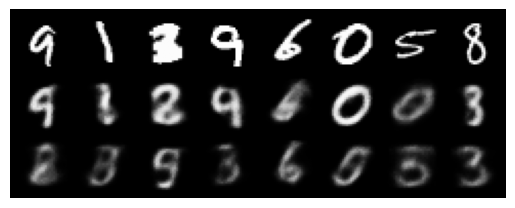

====> Epoch: 2 Average test loss: 147.294295
====> Epoch: 3 Average loss: 146.069219
Reconstructions: 


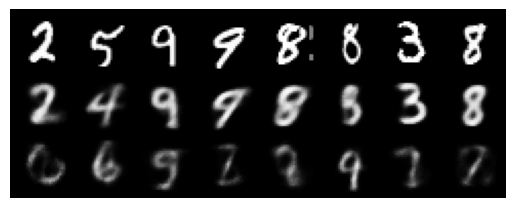

====> Epoch: 3 Average test loss: 143.126093
====> Epoch: 4 Average loss: 142.924126
Reconstructions: 


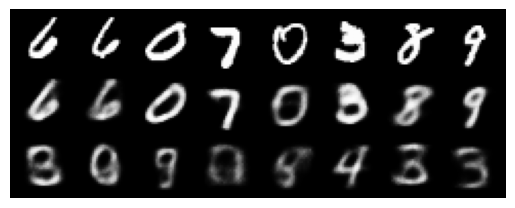

====> Epoch: 4 Average test loss: 141.072833
====> Epoch: 5 Average loss: 141.034282
Reconstructions: 


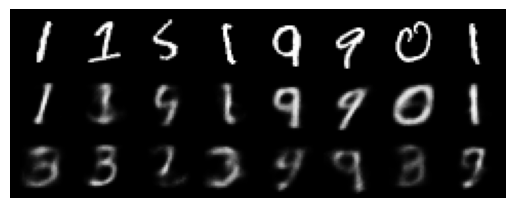

====> Epoch: 5 Average test loss: 139.440988
====> Epoch: 6 Average loss: 139.717210
Reconstructions: 


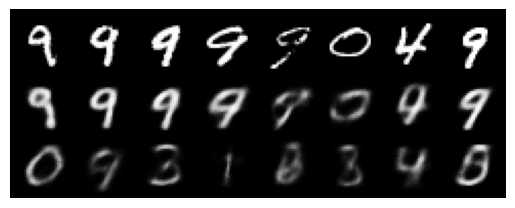

====> Epoch: 6 Average test loss: 138.310871
====> Epoch: 7 Average loss: 138.772259
Reconstructions: 


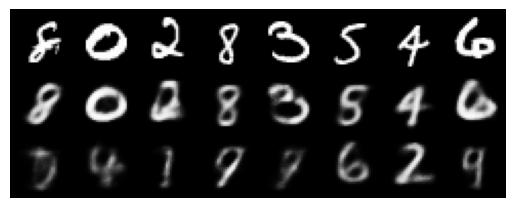

====> Epoch: 7 Average test loss: 137.483447
====> Epoch: 8 Average loss: 137.869800
Reconstructions: 


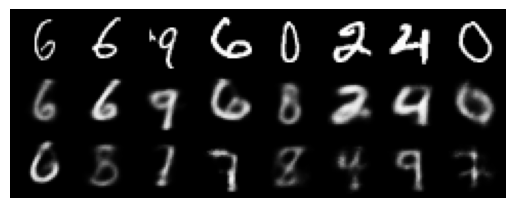

====> Epoch: 8 Average test loss: 136.606316
====> Epoch: 9 Average loss: 137.342578
Reconstructions: 


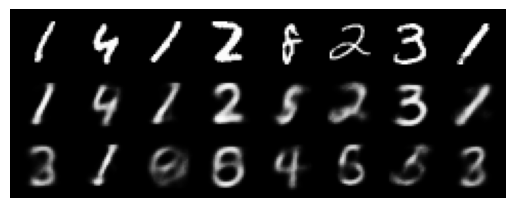

====> Epoch: 9 Average test loss: 136.402897
====> Epoch: 0 Average loss: 208.032345
Reconstructions: 


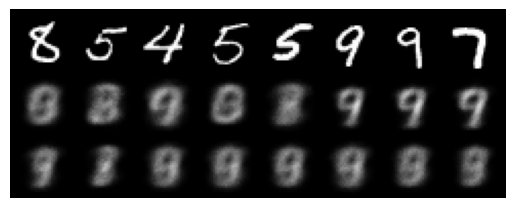

====> Epoch: 0 Average test loss: 189.426180
====> Epoch: 1 Average loss: 180.903287
Reconstructions: 


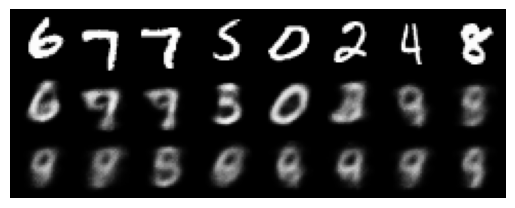

====> Epoch: 1 Average test loss: 170.987220
====> Epoch: 2 Average loss: 167.289199
Reconstructions: 


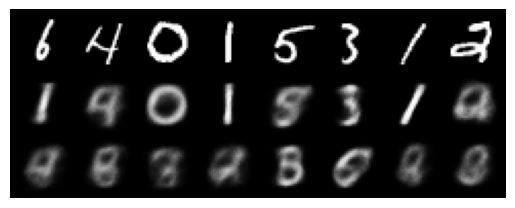

====> Epoch: 2 Average test loss: 163.625800
====> Epoch: 3 Average loss: 162.396518
Reconstructions: 


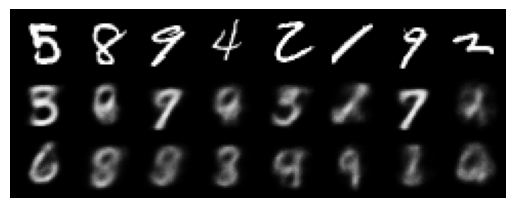

====> Epoch: 3 Average test loss: 160.104022
====> Epoch: 4 Average loss: 159.457961
Reconstructions: 


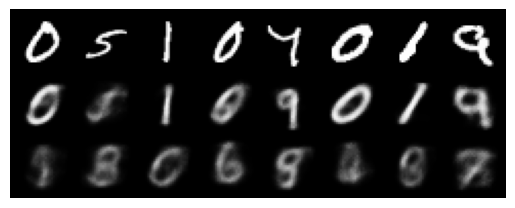

====> Epoch: 4 Average test loss: 158.151956
====> Epoch: 5 Average loss: 157.454841
Reconstructions: 


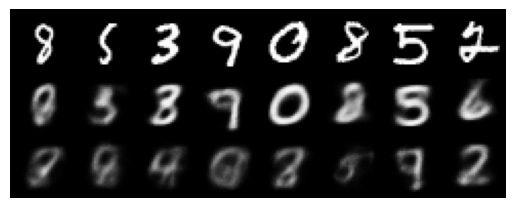

====> Epoch: 5 Average test loss: 156.151920
====> Epoch: 6 Average loss: 155.975413
Reconstructions: 


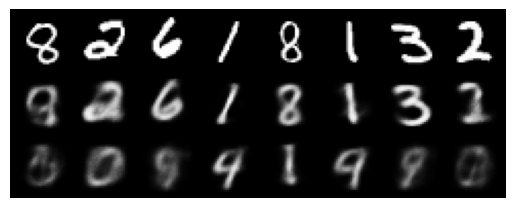

====> Epoch: 6 Average test loss: 154.687059
====> Epoch: 7 Average loss: 154.826382
Reconstructions: 


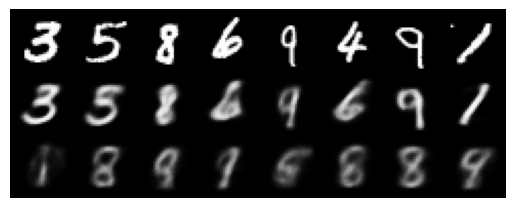

====> Epoch: 7 Average test loss: 153.609049
====> Epoch: 8 Average loss: 153.963711
Reconstructions: 


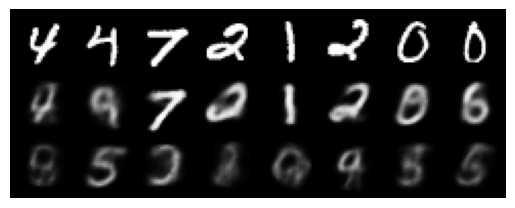

====> Epoch: 8 Average test loss: 152.937990
====> Epoch: 9 Average loss: 153.267620
Reconstructions: 


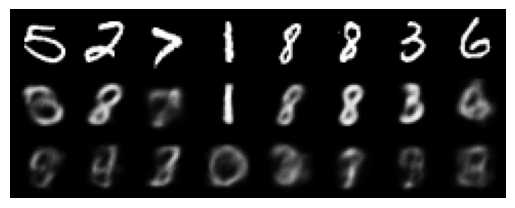

====> Epoch: 9 Average test loss: 152.441192
====> Epoch: 0 Average loss: 214.396520
Reconstructions: 


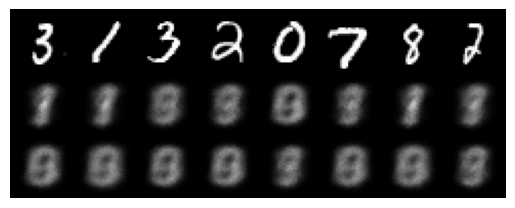

====> Epoch: 0 Average test loss: 201.878361
====> Epoch: 1 Average loss: 200.126089
Reconstructions: 


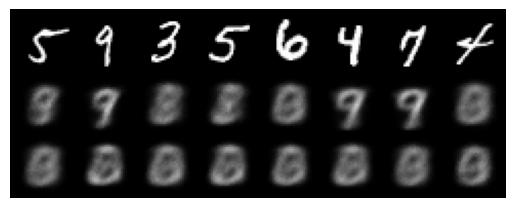

====> Epoch: 1 Average test loss: 195.120319
====> Epoch: 2 Average loss: 191.394612
Reconstructions: 


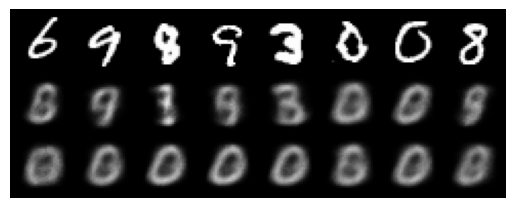

====> Epoch: 2 Average test loss: 186.297155
====> Epoch: 3 Average loss: 183.536403
Reconstructions: 


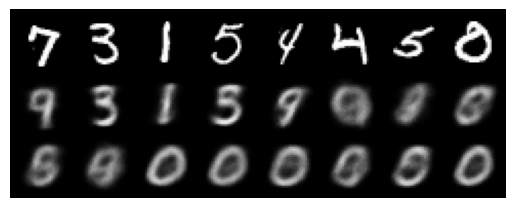

====> Epoch: 3 Average test loss: 180.380458
====> Epoch: 4 Average loss: 179.474247
Reconstructions: 


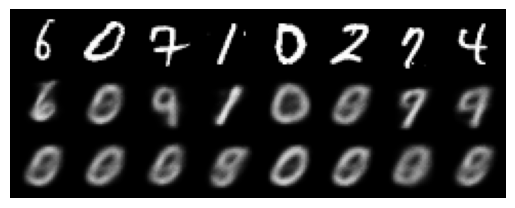

====> Epoch: 4 Average test loss: 177.765929
====> Epoch: 5 Average loss: 177.453230
Reconstructions: 


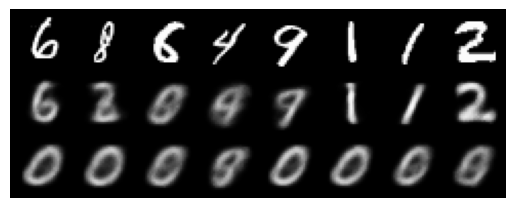

====> Epoch: 5 Average test loss: 176.434479
====> Epoch: 6 Average loss: 175.973717
Reconstructions: 


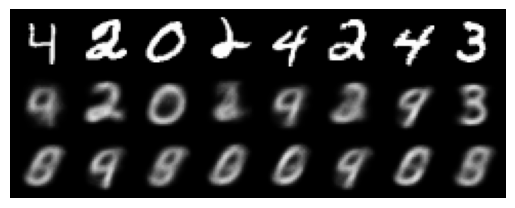

====> Epoch: 6 Average test loss: 175.268637
====> Epoch: 7 Average loss: 175.087779
Reconstructions: 


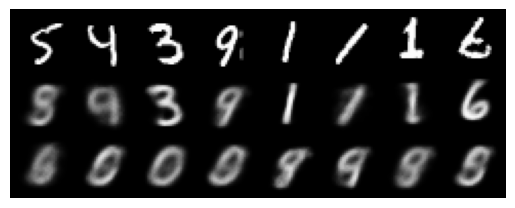

====> Epoch: 7 Average test loss: 174.279641
====> Epoch: 8 Average loss: 174.108471
Reconstructions: 


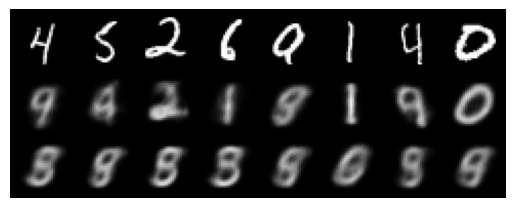

====> Epoch: 8 Average test loss: 173.524745
====> Epoch: 9 Average loss: 173.470487
Reconstructions: 


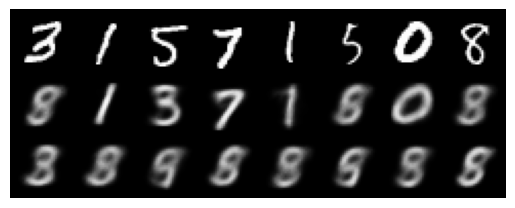

====> Epoch: 9 Average test loss: 172.832034


In [26]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"

hidden_dim = 128
latent_dims = [32, 128, 512]

all_losses = {
  f"vae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in latent_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dim = 256
  # latent_dims =
  num_epochs = 2


for latent_dim in latent_dims:
  # build model and buffer
  vae = VAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device
  )
  buffer = Buffer(size=5000)
  
  # put model on device
  if torch.cuda.is_available():
    vae.cuda()

  # device optimizer
  vae_optimizer = optim.Adam(vae.parameters())

  ######### Your code starts here #########
  # Define the loss function for a Variational Autoencoder.
  def vae_loss_fn(recon_x, x, mu, log_var):
    """
    recon_x: (batch_size, 1, 28, 28)
    x: (batch_size, 1, 28, 28)
    mu: (batch_size, latent_dim)
    log_var: (batch_size, latent_dim)
    """
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu **2 - log_var.exp())
    return recon_loss + kl_loss
  ######### Your code ends here #########

  for epoch in range(0, num_epochs):
    avg_train_loss_epoch = train_single_epoch(
      model_cls="vae",
      model=vae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=vae_optimizer,
      epoch=epoch
    )

    avg_test_loss_epoch = test_single_epoch(
      model_cls="vae",
      model=vae,
      loss_fn=vae_loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"vae{latent_dim}"]["train_losses"].append(avg_train_loss_epoch)
    all_losses[f"vae{latent_dim}"]["test_losses"].append(avg_test_loss_epoch)
  models[f"vae{latent_dim}"] = vae
  buffers[f"vae{latent_dim}"] = buffer

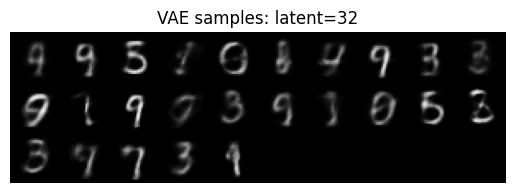

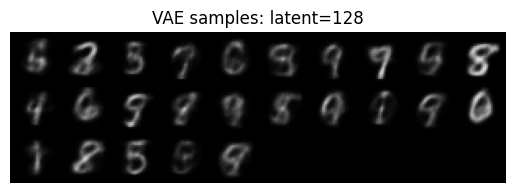

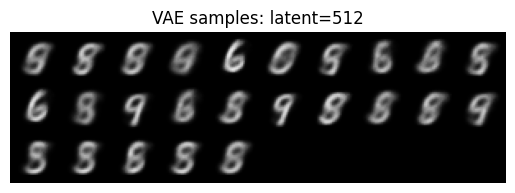

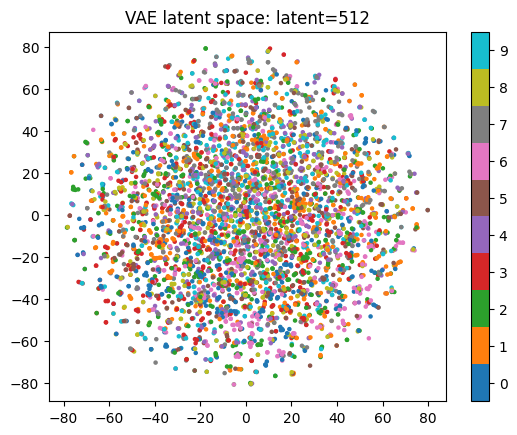

<Figure size 640x480 with 0 Axes>

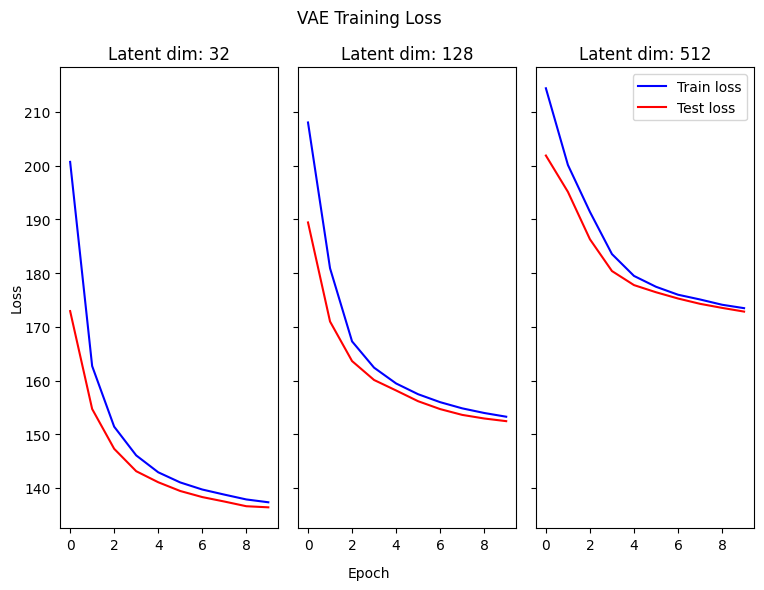

In [27]:
for model_key in ["vae32", "vae128", "vae512"]:
  model = models[model_key]
  buffer = buffers[model_key]
  
  plt.clf()

  title = f"VAE samples: latent={model.latent_dim}"
  viz_samples_vae(model, model_key, title)

  title = f"VAE latent space: latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "vae", latent_dims, f"VAE Training Loss", "vae_losses")


# Bonus task: Conditional VAE

In [29]:
class ConditionalVAE(nn.Module):

  def __init__(
      self,
      input_dim: int,
      hidden_dim: int = 256,
      latent_dim: int= 2,
      embedding_dim: int = 64,
      num_classes: int = 10,
      device: str = "cuda"
  ):
    super(ConditionalVAE, self).__init__()

    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.device = device

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations

    # Separate linear layers to predict the latent mean and logvar

    # Use an embedding layer to encode the class label.
    # See https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html.

    # Choose the correct final layer output activation

    self.label_embed = nn.Embedding(num_classes, embedding_dim)

    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_dim + embedding_dim, hidden_dim),
      nn.ReLU(inplace=True),
      Split(
        nn.Linear(hidden_dim, latent_dim), # mean layer
        nn.Linear(hidden_dim, latent_dim), # logvar layer
      )
    )

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim + embedding_dim, hidden_dim),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_dim, input_dim),
      nn.Sigmoid(), # to get pixel values between 0 and 1
      nn.Unflatten(1, (1, 28, 28))
    )

    ######### Your code ends here #########

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)  # return z sample

  def sample(self, n, class_label=0):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    class_label = torch.tensor(class_label).repeat(n).to(self.device)
    return self.decode(sample, class_label)

  def decode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)
    decoder_input = torch.cat([x, label_embed], dim=-1)
    z = self.decoder(decoder_input)
    return z

  def encode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)

    encoder_input = torch.cat([x.view(x.shape[0], -1), label_embed], dim=-1)
    mu, log_var = self.encoder(encoder_input)

    return mu, log_var

  def forward(self, x, class_label):
    mu, log_var = self.encode(x, class_label)
    z = self.reparameterize(mu, log_var)
    self.latent = z
    return self.decode(z, class_label), mu, log_var

# Bonus task: Train CVAE

====> Epoch: 0 Average loss: 177.410626
Reconstructions: 


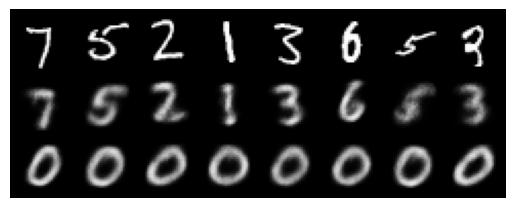

====> Epoch: 0 Average test loss: 150.994721
====> Epoch: 1 Average loss: 145.619905
Reconstructions: 


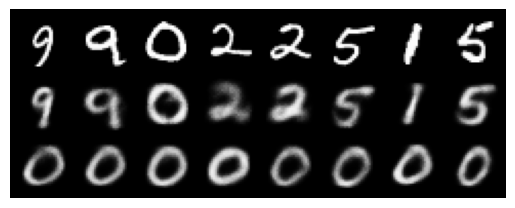

====> Epoch: 1 Average test loss: 140.044495
====> Epoch: 2 Average loss: 138.442024
Reconstructions: 


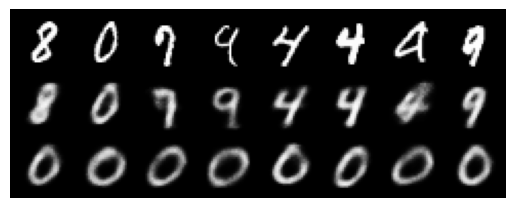

====> Epoch: 2 Average test loss: 135.672257
====> Epoch: 3 Average loss: 134.932619
Reconstructions: 


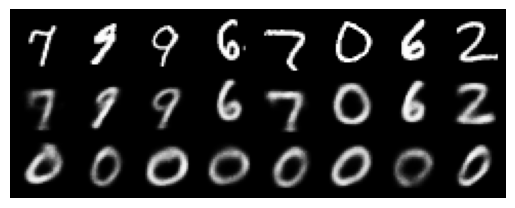

====> Epoch: 3 Average test loss: 132.988117
====> Epoch: 4 Average loss: 132.824263
Reconstructions: 


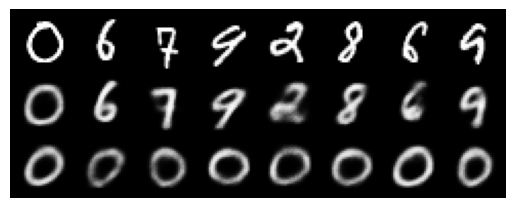

====> Epoch: 4 Average test loss: 131.114289
====> Epoch: 5 Average loss: 131.143502
Reconstructions: 


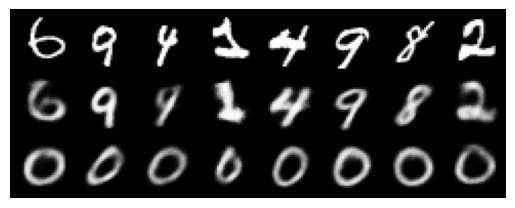

====> Epoch: 5 Average test loss: 129.670016
====> Epoch: 6 Average loss: 130.019968
Reconstructions: 


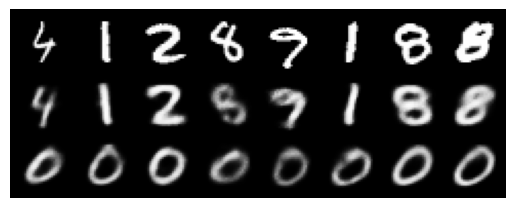

====> Epoch: 6 Average test loss: 128.581613


In [30]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"

hidden_dim = 128
latent_dims = [32, 128, 512]

all_losses = {
  f"cvae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in latent_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dims = [32, 128, 512]
  num_epochs = 2

for latent_dim in latent_dims:
  # build model and buffer
  cvae = ConditionalVAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_classes=10,
    device=device
  )
  buffer = Buffer(size=5000)

  # put model on device
  if torch.cuda.is_available():
    cvae.cuda()

  # device optimizer
  cvae_optimizer = optim.Adam(cvae.parameters())

  for epoch in range(0, num_epochs):
    avg_train_loss_epoch = train_single_epoch(
      model_cls="cvae",
      model=cvae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=cvae_optimizer,
      epoch=epoch
    )

    avg_test_loss_epoch = test_single_epoch(
      model_cls="cvae",
      model=cvae,
      loss_fn=vae_loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"cvae{latent_dim}"]["train_losses"].append(avg_train_loss_epoch)
    all_losses[f"cvae{latent_dim}"]["test_losses"].append(avg_test_loss_epoch)
  models[f"cvae{latent_dim}"] = cvae
  buffers[f"cvae{latent_dim}"] = buffer

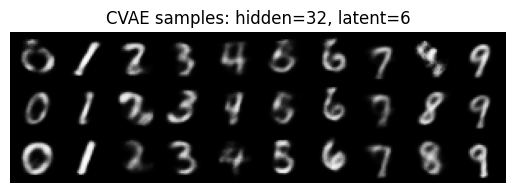

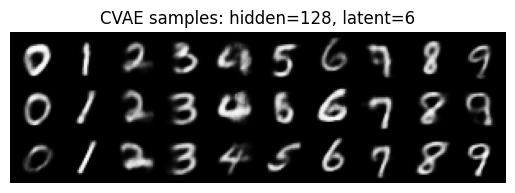

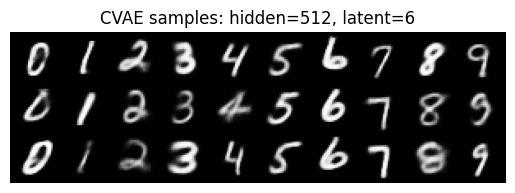

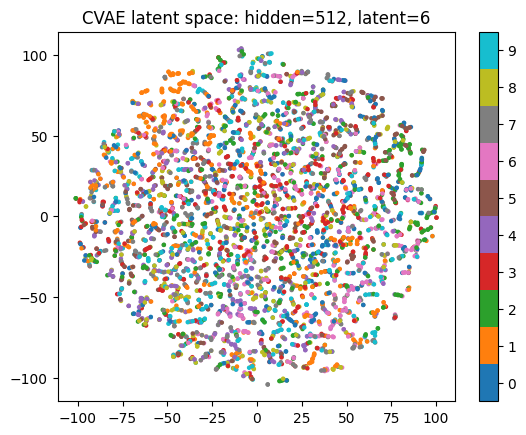

<Figure size 640x480 with 0 Axes>

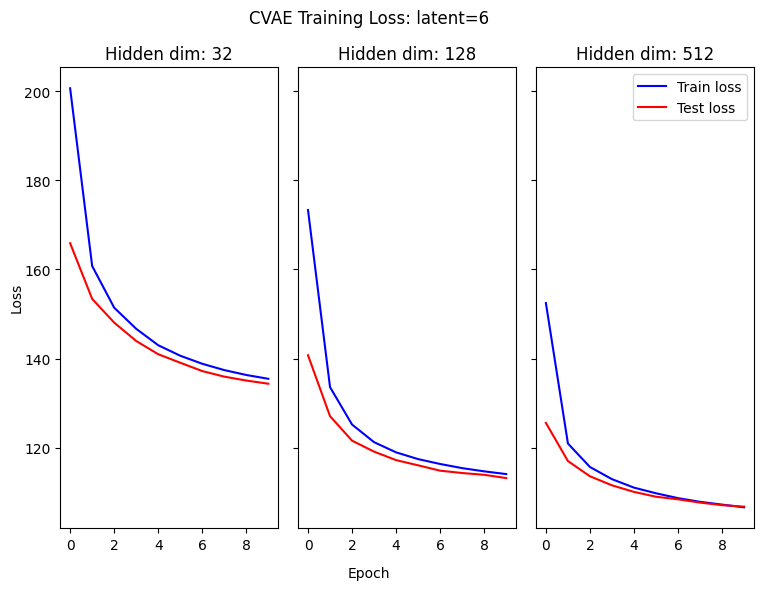

In [ ]:
for model_key in ["cvae32", "cvae128", "cvae512"]:
  model = models[model_key]
  buffer = buffers[model_key]
  
  plt.clf()

  title = f"CVAE samples: latent={model.latent_dim}"
  viz_samples_cvae(model, model_key, title)

  title = f"CVAE latent space: latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "cvae", latent_dims, f"CVAE Training Loss", "cvae_losses")